# Part of the code to generate the 'truth' track for charged particle tracking
This part of the repo generates continuum of (x,y,z) or (r, theta, phi) coordinates of particle, aka track, for a charged particle passing through inner detector

In [ ]:
import numpy as np

In [2]:
PIXEL_LAYERS = (33.25, 50.5, 88.5, 122.5)
initial_params = {
    "x0": 2,
    "y0": 3,
    "z0": 4,
    "px": 60,
    "py": 30,
    "pz": 80,
    "q": 1,
    "B": 2,
}

In [ ]:
def perigee_representation(x, y, z, px, py, pz, q):
    """
    Takes in cartesian coordinates and gives Perigee coordinates
    """
    B = 2  # Tesla
    import numpy as np

    momentum_trans = np.hypot(px, py)
    momentum_mag = np.linalg.norm(x=[px, py, pz])
    theta_polar = np.arccos(pz / momentum_mag)
    azimuth_angle = np.arctan2(py, px)
    signed_curvature = q / momentum_trans
    radius_curvature = momentum_trans / (q * B)

    x_c = x + py / (q * B)
    y_c = y - px / (q * B)

    D = np.hypot(x_c, y_c)
    d0 = D - (np.absolute(radius_curvature))
    z0 = z - (pz / momentum_trans) * d0

    return d0, z0, azimuth_angle, theta_polar, signed_curvature

In [4]:
outs = []
ins = []
perigee_representation(2, 3, 4, 5, 3, 7, -1)

(np.float64(2.60720456117098),
 np.float64(0.8700767460745693),
 np.float64(0.5404195002705842),
 np.float64(0.694537465585555),
 np.float64(-0.17149858514250882))

In [5]:
def evolve_track(x0, y0, z0, px, py, pz, q, B):
    """
    Given initial position and momentum, it evolves the particle's track in Pixel detector
    Track evolution is computed as change of (x,y,z) coordinates over time
    """

    pT = np.hypot(px, py)  # Transverse momentum
    x_c = x0 + py / (q * B)  # Center x-coordinate
    y_c = y0 - px / (q * B)  # Center y-coordinate
    angular_frequency = (q * B) / pT  # Angular frequency (includes sign)
    phi_0 = np.arctan2(y0 - y_c, x0 - x_c)  # Initial phase angle
    R = pT / (abs(q) * B)  # Radius of curvature (always positive)

    # 100 steps of time
    time_steps = np.arange(0, 200, 1)
    arr_phi, arr_x, arr_y, arr_z = [], [], [], []
    for t in time_steps:
        phi_t = phi_0 + angular_frequency * t
        x_t = x_c + R * np.cos(phi_t)
        y_t = y_c + R * np.sin(phi_t)
        z_t = z0 + (pz / pT) * (R * angular_frequency * t)

        arr_phi.append(phi_t)
        arr_x.append(x_t)
        arr_y.append(y_t)
        arr_z.append(z_t)

    return arr_x, arr_y, arr_z, arr_phi

In [6]:
X, Y, Z, P = evolve_track(x0=2, y0=3, z0=4, px=5, py=3, pz=7, q=1, B=2)

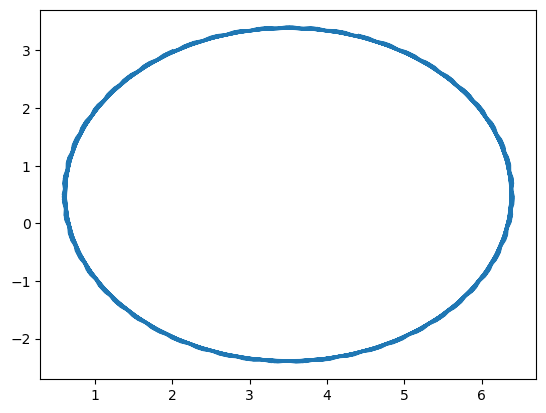

In [7]:
import matplotlib.pyplot as plt

plt.plot(X, Y)

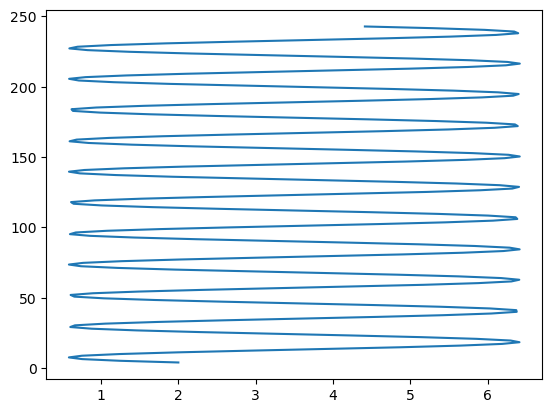

In [15]:
plt.plot(X, Z)

In [ ]:
def intersections_with_layers(x0, y0, z0, px, py, pz, q, B):
    # test points
    # X, Y, Z, P = evolve_track(x0=2, y0=3, z0=4, px=60, py=30, pz=80, q=1, B=2)
    X, Y, Z, P = evolve_track(x0=x0, y0=y0, z0=z0, px=px, py=py, pz=pz, q=q, B=B)
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    P = np.array(P)
    # time_steps = np.arange(0, len(X), 1)
    pixel_layers = (33.25, 50.5, 88.5, 122.5)  # in millimeter
    R_track = np.sqrt(X**2 + Y**2)
    hits = {}

    for layer in pixel_layers:
        delta_r = R_track - layer
        crossing_index = None

        for i in range(len(delta_r) - 1):
            if delta_r[i] * delta_r[i + 1] < 0:
                crossing_index = i
                print(f"Found crossing at index {crossing_index} for layer {layer}")
                break

        if crossing_index is None:
            print(f"No crossing found for layer {layer} mm")
            continue

        r1, r2 = R_track[crossing_index], R_track[crossing_index + 1]
        # t1, t2 = time_steps[crossing_index], time_steps[crossing_index + 1]

        if abs(r1 - r2) > 1e-10:
            alpha = (layer - r1) / (r2 - r1)
            x_hit = X[crossing_index] + alpha * (
                X[crossing_index + 1] - X[crossing_index]
            )
            y_hit = Y[crossing_index] + alpha * (
                Y[crossing_index + 1] - Y[crossing_index]
            )
            z_hit = Z[crossing_index] + alpha * (
                Z[crossing_index + 1] - Z[crossing_index]
            )

            hits[layer] = (x_hit, y_hit, z_hit)
        else:
            if abs(r1 - layer) <= abs(r2 - layer):
                hits[layer] = (X[crossing_index], Y[crossing_index], Z[crossing_index])
            else:
                hits[layer] = (
                    X[crossing_index + 1],
                    Y[crossing_index + 1],
                    Z[crossing_index + 1],
                )

    return hits

In [9]:
intersects = intersections_with_layers(**initial_params)

Found crossing at index 39 for layer 33.25
Found crossing at index 62 for layer 50.5
No crossing found for layer 88.5 mm
No crossing found for layer 122.5 mm


In [10]:
intersects

{33.25: (np.float64(-16.48850392650554),
  np.float64(-28.87367114213788),
  np.float64(50.52160676351015)),
 50.5: (np.float64(-7.460446162756957),
  np.float64(-49.94440002231837),
  np.float64(78.42308609768392))}

In [ ]:
def track_coverage(
    x0, y0, z0, px, py, pz, q, B, pixel_layers=(33.25, 50.5, 88.5, 122.5)
):
    """
    Check if a track with given parameters can geometrically reach all detector layers
    """
    pT = np.hypot(px, py)
    R = pT / (abs(q) * B)
    x_c = x0 + py / (q * B)
    y_c = y0 - px / (q * B)

    center_distance = np.hypot(x_c, y_c)
    min_radius = abs(center_distance - R)
    max_radius = center_distance + R

    reachable_layers = []
    for layer in pixel_layers:
        if min_radius <= layer <= max_radius:
            reachable_layers.append(layer)
    return {
        "reachable_layers": reachable_layers,
        "all_reachable": len(reachable_layers) == len(pixel_layers),
        "track_range": (min_radius, max_radius),
        "center": (x_c, y_c),
        "radius": R,
    }

In [ ]:
def track_with_hits(x0, y0, z0, px, py, pz, q, B, max_attemps=100):
    """
    Determine if a track gets hits in all 4 layers of pixel
    If it hits, return the coordinates of hit.
    If it does not, change the initial parameters so that the new
    track hits all layers. Then return the coordinates of track intersections in (X, Y, Z)
    """
    is_hitting = track_coverage(x0=x0, y0=y0, z0=z0, px=px, py=py, pz=pz, q=q, B=B)
    print(is_hitting)
    if is_hitting["all_reachable"]:
        return intersections_with_layers(
            x0=x0, y0=y0, z0=z0, px=px, py=py, pz=pz, q=q, B=B
        )
    else:
        # threshold = 20
        min_radius = max(PIXEL_LAYERS)
        min_pt = min_radius * abs(q) * B
        current_pt = np.hypot(px, py)

        for attempt in range(max_attemps):
            new_x0, new_y0 = x0, y0
            new_px, new_py = px, py
            # 10% increase every attempt
            aggression_factor = 1.0 + (attempt * 0.1)
            if attempt % 3 == 0:
                if current_pt < min_pt:
                    mom_scale = (min_pt / current_pt) * (1.1 * aggression_factor)
                    new_px = px * mom_scale
                    new_py = py * mom_scale
                else:
                    mom_scale = 1.1 * aggression_factor
                    new_px = px * mom_scale
                    new_py = py * mom_scale

            elif attempt % 3 == 1:
                x_c = x0 + py / (q * B)
                y_c = y0 - px / (q * B)

                position_factor = 0.1 * aggression_factor
                offset_x = -x_c * position_factor
                offset_y = -y_c * position_factor
                new_x0 = x0 + offset_x
                new_y0 = y0 + offset_y

            else:
                mom_scale = (
                    (min_pt / current_pt) * (1.05 * aggression_factor)
                    if current_pt < min_pt
                    else (1.05 * aggression_factor)
                )
                new_px = px * mom_scale
                new_py = py * mom_scale

                x_c = x0 + py / (q * B)
                y_c = y0 - px / (q * B)
                position_factor = 0.05 * aggression_factor
                offset_x = -x_c * position_factor
                offset_y = -y_c * position_factor
                new_x0 = x0 + offset_x
                new_y0 = y0 + offset_y

            print(new_x0, new_y0, z0, new_px, new_py, pz, q, B)
            new_coverage = track_coverage(new_x0, new_y0, z0, new_px, new_py, pz, q, B)
            print(new_coverage)
            if new_coverage["all_reachable"]:
                print(f"Success on attempt {attempt + 1}")
                print("Returning")
                return intersections_with_layers(
                    new_x0, new_y0, z0, new_px, new_py, pz, q, B
                )
        print(f"Failed to find valid track after {max_attemps} attempts")
        return None

In [ ]:
x = track_with_hits(**initial_params)

{'reachable_layers': [33.25, 50.5], 'all_reachable': False, 'track_range': (np.float64(1.6349073954092113), np.float64(65.44713192958447)), 'center': (17.0, -27.0), 'radius': np.float64(33.54101966249684)}
2 3 4 241.04812797447735 120.52406398723868 80 1 2
{'reachable_layers': [33.25, 50.5, 88.5, 122.5], 'all_reachable': True, 'track_range': (np.float64(1.7520066164491084), np.float64(267.7479933835509)), 'center': (np.float64(62.26203199361934), np.float64(-117.52406398723868)), 'radius': np.float64(134.75)}
Success on attempt 1
Returning
Found crossing at index 36 for layer 33.25
Found crossing at index 54 for layer 50.5
Found crossing at index 93 for layer 88.5
Found crossing at index 131 for layer 122.5


In [14]:
x

{33.25: (np.float64(-28.184615531975307),
  np.float64(-17.64038714916184),
  np.float64(14.888349863974268)),
 50.5: (np.float64(-40.42237202410888),
  np.float64(-30.269983251264307),
  np.float64(20.1124431264569)),
 88.5: (np.float64(-61.320321472282274),
  np.float64(-63.81270733765164),
  np.float64(31.886327136906857)),
 122.5: (np.float64(-71.29222050657833),
  np.float64(-99.6174202905359),
  np.float64(42.95463692529251))}